In [1]:
import sys, os, inspect
current_dir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parent_dir = os.path.dirname(current_dir)
sys.path.insert(0, parent_dir)
sys.path.insert(0, os.path.join(parent_dir,'spring-break'))
sys.path.insert(0, os.path.join(parent_dir,'Linear\ Classifier'))

In [2]:
import numpy as np
import random
import copy
import math
from tqdm import tqdm
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
from martins.complex_transformer import ComplexTransformer
from FNNLinear import FNNLinear
from FNNSeparated import FNNSeparated
from GAN import Generator, Discriminator
from data_utils import *
import argparse
import logging
import logging.handlers
import pickle
from centerloss import CenterLoss
from FNN import FNN
from GAN import Generator, Discriminator
from sklearn.manifold import TSNE
import seaborn as sns 
import matplotlib.pyplot as plt

In [3]:
class JoinDataset(Dataset):
    def __init__(self, source_x, source_y, target_x, target_y, random=False):
        self.source_x = source_x
        self.source_y = source_y
        self.target_x = target_x
        self.target_y = target_y
        
        self.source_len = self.source_y.shape[0]
        self.target_len = self.target_y.shape[0]
    
        self.random = random
    def __len__(self):
        return self.target_len
    
    def __getitem__(self, index):
        if self.random:
            index_source = random.randrange(source_len)
            index_target = random.randrange(target_len)
        else:
            index_source = index
            index_target = index

        return (self.source_x[index_source], self.source_y[index_source]), (self.target_x[index_target], self.target_y[index_target])
    
    
class SingleDataset(Dataset):
    def __init__(self, x, y):
            self.x = x
            self.y = y
            self.len = self.y.shape[0]
    
    def __len__(self):
        return self.len
    
    def __getitem__(self, index):
        return self.x[index], self.y[index]


In [4]:
# local only
class local_args:
    def __init__(self, **entries):
        self.__dict__.update(entries)
        
args = local_args(**{
    'data_path': '/Users/tianqinli/Code/Russ/time-series-domain-adaptation/data_unzip',
    'task': '3E',
    'num_class': 50,
    'batch_size': 100,
    'num_per_class': -1,
    'gap': 5,
    'lbl_percentage':0.7,
    'lr_gan': 1e-4,
    'lr_FNN': 1e-4,
    'lr_encoder': 1e-4,
    'epochs': 2,
    'clip_value': 0.01,
    'n_critic': 4,
    'sclass': 0.7,
    'scent': 1e-2,
    'seed': None,
    'save_path': '/Users/tianqinli/Code/Russ/time-series-domain-adaptation/train_related',
    'model_save_period': 1,
    'lr_centerloss': 1e-3,
    'seed': 0,
    'select_pretrain_epoch': 509, 
    'sbinary_loss': 1,
    
})

In [5]:
device = torch.device('cuda:{}'.format(args.gpu_num) if torch.cuda.is_available() else 'cpu')

# seed
torch.manual_seed(args.seed)
torch.cuda.manual_seed(args.seed)
np.random.seed(args.seed)
cudnn.deterministic = True
torch.backends.cudnn.deterministic = True


args.task = '3Av2' if args.task == '3A' else '3E'
num_class = 50 if args.task == "3Av2" else 65
device = torch.device('cuda:{}'.format(args.gpu_num) if torch.cuda.is_available() else 'cpu')

if args.num_per_class == -1:
    args.num_per_class = math.ceil(args.batch_size / num_class)
    
model_sub_folder = '/stepc_binary/task_%s_lrFNN_%f_sbinary_loss_%f'%(args.task, args.lr_FNN, args.sbinary_loss)

if not os.path.exists(args.save_path+model_sub_folder):
    os.makedirs(args.save_path+model_sub_folder)

In [6]:
def weights_init(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_uniform_(m.weight)
    elif type(m) == nn.LayerNorm:
        torch.nn.init.normal_(m.weight, 1.0, 0.02)
        torch.nn.init.constant_(m.bias, 0)


In [7]:
def encoder_inference(encoder, encoder_MLP, x):
    real = x[:,:,0].reshape(x.size(0), seq_len, feature_dim).float()
    imag = x[:,:,1].reshape(x.size(0), seq_len, feature_dim).float()
    real, imag = encoder(real, imag)
    cat_embedding = torch.cat((real[:,-1,:], imag[:,-1,:]), -1).reshape(x.shape[0], -1)
    cat_embedding = encoder_MLP(cat_embedding)
    return cat_embedding

In [8]:
def encoder_inference(encoder, encoder_MLP, x):
    real = x[:,:,0].reshape(x.size(0), seq_len, feature_dim).float()
    imag = x[:,:,1].reshape(x.size(0), seq_len, feature_dim).float()
    real, imag = encoder(real, imag)
    cat_embedding = torch.cat((real[:,-1,:], imag[:,-1,:]), -1).reshape(x.shape[0], -1)
    cat_embedding = encoder_MLP(cat_embedding)
    return cat_embedding


device = torch.device('cuda:{}'.format(args.gpu_num) if torch.cuda.is_available() else 'cpu')
print(device)

seq_len = 10
feature_dim = 160
encoder = ComplexTransformer(layers=3,
                               time_step=seq_len,
                               input_dim=feature_dim,
                               hidden_size=64,
                               output_dim=64,
                               num_heads=8,
                               out_dropout=0.2,
                               leaky_slope=0.2).to(device)
encoder_MLP = FNNSeparated(d_in=64 * 2 * 1, d_h1=500, d_h2=500, dp=0.2).to(device)
CNet = FNNLinear(d_h2=500, d_out=num_class).to(device)
GNet = Generator(dim=500).to(device)

criterion_classifier = nn.CrossEntropyLoss().to(device)
criterion_centerloss = CenterLoss(num_classes=num_class, feat_dim=500, use_gpu=torch.cuda.is_available()).to(device)
# criterion_probloss = BinaryLoss(device).to(device)

GNet.apply(weights_init)
encoder.apply(weights_init)
encoder_MLP.apply(weights_init)
CNet.apply(weights_init)

optimizerG = torch.optim.Adam(GNet.parameters(), lr=args.lr_gan)
optimizerCNet = torch.optim.Adam(CNet.parameters(), lr=args.lr_FNN)
optimizerEncoderMLP = torch.optim.Adam(encoder_MLP.parameters(), lr=args.lr_encoder)
optimizerEncoder = torch.optim.Adam(encoder.parameters(), lr=args.lr_encoder)
optimizerCenterLoss = torch.optim.Adam(criterion_centerloss.parameters(), lr=args.lr_centerloss)



cpu


In [9]:

# pre-trained
select_pretrain_epoch = 180
# sbinary = 1
model_PATH = '../train_related/pretrain/binary_balance_linear_acc49'
CNet.load_state_dict(torch.load(model_PATH+'/CNet_{}.t7'.format(select_pretrain_epoch), map_location=device))
encoder.load_state_dict(torch.load(model_PATH+'/encoder_{}.t7'.format(select_pretrain_epoch), map_location=device))
encoder_MLP.load_state_dict(torch.load(model_PATH+'/encoder_MLP_{}.t7'.format(select_pretrain_epoch), map_location=device))
GNet.load_state_dict(torch.load(model_PATH+'/GNet_{}.t7'.format(select_pretrain_epoch), map_location=device))

correct_target = 0.0
num_datas = 0.0
CNet.eval()
encoder.eval()
encoder_MLP.eval()
GNet.eval()


Generator(
  (net): Sequential(
    (0): Linear(in_features=500, out_features=300, bias=True)
    (1): LayerNorm((300,), eps=1e-05, elementwise_affine=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
    (3): Linear(in_features=300, out_features=500, bias=True)
    (4): LayerNorm((500,), eps=1e-05, elementwise_affine=True)
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
    (6): Linear(in_features=500, out_features=500, bias=True)
    (7): LayerNorm((500,), eps=1e-05, elementwise_affine=True)
    (8): LeakyReLU(negative_slope=0.2, inplace=True)
    (9): Linear(in_features=500, out_features=300, bias=True)
    (10): LayerNorm((300,), eps=1e-05, elementwise_affine=True)
    (11): LeakyReLU(negative_slope=0.2, inplace=True)
    (12): Linear(in_features=300, out_features=500, bias=True)
    (13): LayerNorm((500,), eps=1e-05, elementwise_affine=True)
  )
)

In [10]:
raw_data = np.load(args.data_path+'/processed_file_not_one_hot_%s.pkl'%args.task, allow_pickle=True)
source_data = raw_data['tr_data']

In [11]:
torch.manual_seed(123)
s_index = torch.randperm(source_data.shape[0])[:3750]


In [16]:
s_index = torch.randperm(source_data.shape[0])[:3750]

source_x = source_data[s_index]
source_y = raw_data['tr_lbl'][s_index]

source_binary_target_unlabel_x_embedding_all = encoder_inference(encoder, encoder_MLP, torch.tensor(source_x))


In [17]:
tsne = TSNE()
source_binary_embedded = tsne.fit_transform(source_binary_target_unlabel_x_embedding_all.detach())

Text(0.5, 1.0, 'Probability Classifier (source + target_labeled): tSNE plot of source_label_embedding')

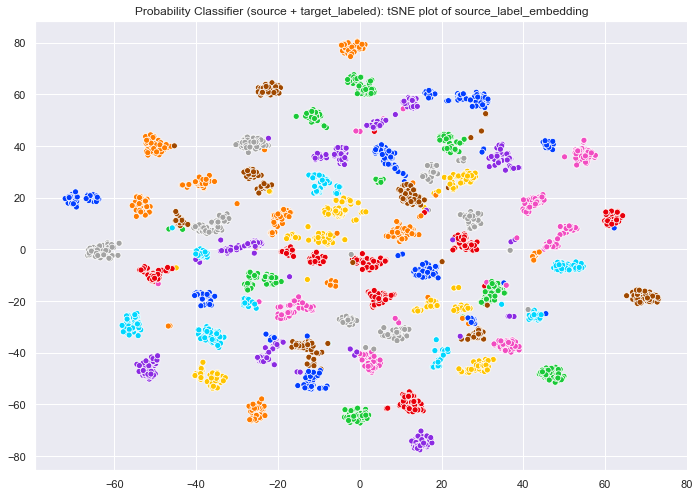

In [18]:
# plot 
# linear unlabeled
sns.set(rc={'figure.figsize':(11.7,8.27)})
palette = sns.color_palette("bright", 65)

g = sns.scatterplot(source_binary_embedded[:,0], source_binary_embedded[:,1], hue=source_y, legend=False, palette=palette)

plt.title('Probability Classifier (source + target_labeled): tSNE plot of source_label_embedding')